<a href="https://colab.research.google.com/github/ElliotDickman/VQGAN/blob/main/VQGAN_Video_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##About this Notebook


Based on the notebook by Katherine Crowson (https://github.com/crowsonkb), with explanations, and modifications by Eleiber#8347, using the keyframe method created by Chigozie Nri (https://github.com/chigozienri).

After Effects/JSON driven animation, RIFE integration, performance enhancements, and additional workflow and UI enhancements by Elliot Dickman (https://github.com/elliotdickman).

###Licensed under the MIT License

Copyright (c) 2021 Katherine Crowson

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

#Setup and Downloads

In [ ]:
#@title #**Check GPU**
!nvidia-smi

Mon Dec  6 19:39:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# @title #**Set working directory**
using_drive = False #@param {type:'boolean"}

# @markdown *Note: Drive integration is not fully tested*

if using_drive:
  from google.colab import drive
  drive.mount('/content/gdrive')

  working_dir = '/content/gdrive/MyDrive/vqgan'
  print("Mounted Drive")
else:
  working_dir = '/content'
  print("Set directory to current runtime")

Set directory to current runtime


In [ ]:
# @title #**Install libraries**
# @markdown This may take a sec

print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP                 &> /dev/null
 
print("Downloading Python AI libraries...")
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
 
print("Installing libraries for handling metadata...")
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null
 
print("Installing Python video creation libraries...")
!pip install imageio-ffmpeg &> /dev/null
path = f'{working_dir}/steps'
!mkdir --parents {path}
print("Installation finished.")

Installing libraries for handling metadata...
Installing Python video creation libraries...
Installation finished.


In [ ]:
#@title #**Download training data**

imagenet_1024 = False #@param {type:"boolean"}
imagenet_16384 = True #@param {type:"boolean"}
coco = False #@param {type:"boolean"}
faceshq = False #@param {type:"boolean"}
wikiart_16384 = False #@param {type:"boolean"}
sflckr = False #@param {type:"boolean"}

if imagenet_1024:
  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
if wikiart_16384:
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    808      0 --:--:-- --:--:-- --:--:-- 98857
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.7M      0  0:01:03  0:01:03 --:--:-- 14.9M


In [ ]:
# @title #**Load libraries**
# @markdown For math and stuff

import argparse
import math
from pathlib import Path
import sys
import os
import cv2
import pandas as pd
import numpy as np
import subprocess
 
sys.path.append('./taming-transformers')

# Some models include transformers, others need explicit pip install
try:
    import transformers
except Exception:
    !pip install transformers
    import transformers

from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

#Instructions

##Parameters for Image and Video Generation

| Parameter  |  Usage |
|---|---|
| `key_frames` | Whether to use key frames to change the parameters over the course of the run |
|  `text_prompts` |  Text prompts, separated by "\|" |
| `width` | Width of the output, in pixels. This will be rounded down to a multiple of 16 |
| `height` | Height of the output, in pixels. This will be rounded down to a multiple of 16 |
| `model` | Choice of model, must be downloaded above |
| `interval` | How often to display the frame in the notebook (doesn't affect the actual output) |
| `initial_image` | Image to start with (relative path to file) |
| `target_images` | Image prompts to target, separated by "\|" (relative path to files) |
| `seed` | Random seed, if set to a positive integer the run will be repeatable (get the same output for the same input each time, if set to -1 a random seed will be used. |
| `max_frames` | Number of frames for the animation |
| `angle` | Angle in degrees to rotate clockwise between each frame |
| `zoom` | Factor to zoom in each frame, 1 is no zoom, less than 1 is zoom out, more than 1 is zoom in (negative is uninteresting, just adds an extra 180 rotation beyond that in angle) |
| `translation_x` | Number of pixels to shift right each frame |
| `translation_y` | Number of pixels to shift down each frame |
| `iterations_per_frame` | Number of times to run the VQGAN+CLIP method each frame |
| `save_all_iterations` | Debugging, set False in normal operation |
| `interpolate_frames` | Whether to interpolate between keyframes. If disabled, sets interpolate method to `pad`.<br>Recommend disabling when using json animation data, since linear interpolation is applied automatically when generating keyframes from json data |
| `interpolate_text_prompts` | Whether to interpolate between text prompt keyframes. Recommend keeping this enabled, even if disabling interpolation for transform attributes |
| `interpolation_method` | Sets method for pd.Series.interpolate for keyframe processing. Ignored if `interpolate_frames` is disabled |
| `use_json` | Whether to use json animation data for keyframes. Enabling this will override the `key_frames`, `max_frames`, `angle`, `zoom`, `translation_x`, and `translation_y` parameters |
| `json_file` | Path to json file |

##Transformations

On each frame, the network restarts, is fed a version of the output zoomed in by `zoom` as the initial image, rotated clockwise by `angle` degrees, translated horizontally by `translation_x` pixels, and translated vertically by `translation_y` pixels. Then it runs `iterations_per_frame` iterations of the VQGAN+CLIP method. 0 `iterations_per_frame` is supported, to help test out the transformations without changing the image.

For `iterations_per_frame = 1` (recommended for more abstract effects), the resulting images will not have much to do with the prompts, but at least one prompt is still required.

In normal use, only the last iteration of each frame will be saved, but for trouble-shooting you can set `save_all_iterations` to True, and every iteration of each frame will be saved.

##Prompts and weights

Input generation prompts in the `text_prompts` field. It is a list because you can put more than one text, and so the AI tries to 'mix' the images, giving the same priority to both texts. You can also assign weights, to bias the priority towards one prompt or another, or negative weights, to remove an element (for example, a colour).

Example of weights with decimals:

Text : rubber:0.5 | rainbow:0.5

To use an initial image to the model, you just have to upload a file to the Colab environment (in the section on the left), and then modify `initial_image`: putting the exact name of the file. Example: sample.png

You can also change the model by changing the line that says `model`. Currently 1024, 16384, WikiArt, S-FLCKR and COCO-Stuff are available. To activate them you have to have downloaded them first, and then you can simply select it.

You can also use `target_images`, which is basically putting one or more images on it that the AI will take as a "target", fulfilling the same function as putting text on it. To put more than one you have to use | as a separator.

##Keyframes

If `key_frames` is set to True, you are able to change the parameters over the course of the run.
To do this, put the parameters in in the following format:
10:(0.5), 20: (1.0), 35: (-1.0)

This means at frame 10, the value should be 0.5, at frame 20 the value should be 1.0, and at frame 35 the value should be -1.0. The value at each other frame will be linearly interpolated (that is, before frame 10, the value will be 0.5, between frame 10 and 20 the value will increase frame-by-frame from 0.5 to 1.0, between frame 20 and 35 the value will decrease frame-by-frame from 1.0 to -1.0, and after frame 35 the value will be -1.0)

This also works for text_prompts, e.g. 10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)
will start with an Apple value of 1, once it hits frame 10 it will start decreasing in in Apple and increasing in Orange until it hits frame 20. Note that Peach will have a value of 1 the whole time.

If `key_frames` is set to True, all of the parameters which can be key-framed must be entered in this format. The script will  attempt to reformat imporperly formatted inputs, and will display a warning with the corrected formatting.

##JSON Keyframing with After Effects

The `use_json` parameter allows you to import a JSON file from After Effects to drive the transform keyframes.

###Exporting JSON from AE

In After Effects, create a composition with a single element (in a composition with multiple elements, only the first will be processed).

Transform properties of this element can be keyed, including Rotate, Scale, and Position, corresponding to the `angle`, `zoom`, and `translate_x` and `translate_y` parameters.

When using expressions to animate in AE, bake the animation before exporting either by using the AE keyframe assistant or the Bodymovin export option.

Any keyframes that are not linearly interpolated in AE should be baked as well, since the JSON parser will only apply linear interpolation.

The JSON parser here uses the Bodymovin JSON export format. Install the Bodymovin plugin from https://aescripts.com/bodymovin/.

In the Bodymovin export window, disable all optional export settings for optimal performance. Parsing with additional settings enabled is untested. If using expressions, you can enable `Convert expressions to keyframes` under `Expression options` if you have not already baked the animation.

The resulting JSON file can then be used in this script to drive image generation.

##RIFE Interpolation Smoothing

We can use [RIFE](https://github.com/hzwer/arXiv2020-RIFE/) to smooth out the video and reduce the number of VQGAN-generated frames to improve performance.

The `smoothing_exponent` parameter determines the number of frames to interpolate between each frame of generated video, as a power of 2. For example, setting `smoothing_exponent` to 3 would generate 8 interpolated frames for every original frame of footage.

The `scale` parameter can be used to reduce the size of generated images. This is recommended when working with high-resolution images of 4k or greater.

#Generate Images and Video

In [ ]:
#@title **Parameters**

key_frames = True #@param {type:"boolean"}
text_prompts = "0:(your text prompt here:1)" #@param {type:"string"}
width =  400#@param {type:"number"}
height =  400#@param {type:"number"}
model = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
interval =  5#@param {type:"number"}
initial_image = ""#@param {type:"string"}
target_images = ""#@param {type:"string"}
seed = 1#@param {type:"number"}
max_frames = 25#@param {type:"number"}
angle = "0:(0)"#@param {type:"string"}
zoom = "0:(1.3)"#@param {type:"string"}
translation_x = "0:(0)"#@param {type:"string"}
translation_y = "0:(0)"#@param {type:"string"}
iterations_per_frame = "0:(20)"#@param {type:"string"}
save_all_iterations = False#@param {type:"boolean"}
interpolate_frames = True#@param {type:"boolean"}
interpolate_text_prompts = True#@param {type:"boolean"}
interpolation_method = "linear"#@param ["linear", "quadratic", "cubic"]
use_json = False#@param {type:"boolean"}
json_file = "animation_01.json"#@param {type:"string"}

In [ ]:
#@title **Parse JSON data**

import json

show_output = False#@param{type:"boolean"}
verbose = show_output

if use_json:
  # Initialize keyframes library
  keyframes = {
      'angle': [],
      'horizontal': [],
      'vertical': [],
      'zoom': []
  }

  # Open file
  f = open(json_file)

  data = json.load(f)

  if verbose: print(f'Total frames: {data["op"]}')

  max_frames = data["op"]

  keys = data['layers'][0]['ks']

  # Iterate through the json data
  # VQGAN parameters are set up to parse keyframe data in the form of:
  # frame:(value), frame:(value)
  # So we parse AE json data to that format to be passed off to VQGAN parser

  for i in keys:
    if i == "r":
      p_frame = 0
      new_frame = 0
      old_value = 0
      new_value = 0
      if verbose: print("Angle:\n")
      for key in keys[i]['k']:
        if verbose: print(f'Frame: {key["t"]}, Value: {key["s"][0]}')
        new_frame = key["t"]
        # We might have to make this negative
        new_value = -key["s"][0]
        diff = new_value - old_value
        frame_diff = new_frame - p_frame
        if frame_diff != 0:
          keyframes['angle'].append(f'{p_frame}:({(diff / (frame_diff)):.5f})')
        p_frame = new_frame
        old_value = new_value
      keyframes['angle'].append(f'{p_frame}:(0)')

    if i == "p":
      p_frame = 0
      new_frame = 0
      old_h_value = 0
      new_h_value = 0
      old_v_value = 0
      new_v_value = 0
      if verbose: print("\n\nTranslate:\n")
      for key in keys[i]['k']:
        if verbose: print(f'Frame: {key["t"]}, Horizontal: {key["s"][0]}, Vertical: {key["s"][1]}')
        new_frame = key["t"]
        new_h_value = key["s"][0]
        new_v_value = key["s"][1]
        # If this is the first time we're seeing a translate value:
        if new_frame == 0:
          # We can set the diff to 0 cuz position will be relative to the starting position in AE
          old_h_value = new_h_value
          old_v_value = new_v_value
        diff_h = new_h_value - old_h_value
        diff_v = new_v_value - old_v_value
        frame_diff = new_frame - p_frame
        # print(f'old h: {old_h_value}, new h: {new_h_value}, p_frame: {p_frame}, new_frame: {new_frame}')
        if frame_diff != 0:
          keyframes['horizontal'].append(f'{p_frame}:({(diff_h / (frame_diff)):.5f})')
          keyframes['vertical'].append(f'{p_frame}:({(diff_v / (frame_diff)):.5f})')
        p_frame = new_frame
        old_h_value = new_h_value
        old_v_value = new_v_value
      keyframes['horizontal'].append(f'{p_frame}:(0)')
      keyframes['vertical'].append(f'{p_frame}:(0)')


    if i == "s":
      p_frame = 0
      new_frame = 0
      old_value = 0
      new_value = 0
      if verbose: print("\n\nZoom:\n")
      for key in keys[i]['k']:
        if verbose: print(f'Frame: {key["t"]}, Value: {key["s"][0]}')
        new_frame = key["t"]
        new_value = key["s"][0]
        # diff needs to be different for scale, since its a factor by which to zoom in
        diff = 0
        if old_value != 0:
          diff = (new_value / old_value) - 1
        frame_diff = new_frame - p_frame
        if frame_diff != 0:
          keyframes['zoom'].append(f'{p_frame}:({1 + (diff / frame_diff):.5f})')
        p_frame = new_frame
        old_value = new_value
      keyframes['zoom'].append(f'{p_frame}:(1)')

  if verbose: print('\n---\n')

  for keyframe in keyframes:
    keyframes[keyframe] = ", ".join(keyframes[keyframe])

  if verbose: print("Generated keyframes:")
  if verbose:
    for keyframe in keyframes:
      print(f'{keyframe}: {keyframes[keyframe]}')

  angle = keyframes['angle']
  translation_x = keyframes['horizontal']
  translation_y = keyframes['vertical']
  zoom = keyframes['zoom']
  key_frames = True

  # Close file
  f.close()

print(f'\nUpdated values:\nkey_frames: {key_frames}\nmax_frames: {max_frames}\nangle: {angle}\ntranslation_x: {translation_x}\ntranslation_y: {translation_y}\nzoom: {zoom}')


Updated values:
key_frames: True
max_frames: 110
angle: 0:(0.00000), 1:(0.00000), 2:(0.00000), 3:(0.00000), 4:(0.00000), 5:(0.00000), 6:(0.00000), 7:(0.00000), 8:(0.00000), 9:(0.00000), 10:(0.00000), 11:(0.00000), 12:(0.00000), 13:(0.00000), 14:(0.00000), 15:(0.00000), 16:(0.00000), 17:(0.00000), 18:(0.00000), 19:(0.00000), 20:(0.00000), 21:(-0.04900), 22:(-0.15300), 23:(-0.25500), 24:(-0.35700), 25:(-0.45800), 26:(-0.55900), 27:(-0.65800), 28:(-0.75600), 29:(-0.85500), 30:(-0.95200), 31:(-1.04800), 32:(-1.14400), 33:(-1.23800), 34:(-1.33300), 35:(-1.42700), 36:(-1.51900), 37:(-1.61100), 38:(-1.70200), 39:(-1.79300), 40:(-1.88300), 41:(-1.97100), 42:(-2.06000), 43:(-2.14700), 44:(-2.23300), 45:(-2.32000), 46:(-2.40500), 47:(-2.49000), 48:(-2.57300), 49:(-2.65600), 50:(-2.73800), 51:(-2.81900), 52:(-2.90000), 53:(-2.98000), 54:(-3.05900), 55:(-3.13700), 56:(-3.21400), 57:(-3.29100), 58:(-3.36600), 59:(-3.44100), 60:(-3.51500), 61:(-3.58700), 62:(-3.66000), 63:(-3.73100), 64:(-3.80100),

In [ ]:
#@title **Process parameters**

if initial_image != "":
    print(
        "WARNING: You have specified an initial image. Note that the image resolution "
        "will be inherited from this image, not whatever width and height you specified. "
        "If the initial image resolution is too high, this can result in out of memory errors."
    )
elif width * height > 160000:
    print(
        "WARNING: The width and height you have specified may be too high, in which case "
        "you will encounter out of memory errors either at the image generation stage or the "
        "video synthesis stage. If so, try reducing the resolution"
    )
model_names={
    "vqgan_imagenet_f16_16384": 'ImageNet 16384',
    "vqgan_imagenet_f16_1024":"ImageNet 1024", 
    "wikiart_1024":"WikiArt 1024",
    "wikiart_16384":"WikiArt 16384",
    "coco":"COCO-Stuff",
    "faceshq":"FacesHQ",
    "sflckr":"S-FLCKR"
}
model_name = model_names[model]

if seed == -1:
    seed = None

def parse_key_frames(string, prompt_parser=None):
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False, is_text_prompt=False):
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])
    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    if interpolate_frames or (interpolate_text_prompts and is_text_prompt):
      print("Interpolating keyframes")
      key_frame_series = key_frame_series.interpolate(method=interpolation_method, limit_direction='both')
    else:
      key_frame_series = key_frame_series.interpolate(method='pad', limit_direction='forward')
    if integer:
      return key_frame_series.astype(int)
    return key_frame_series

def split_key_frame_text_prompts(frames):
    prompt_dict = dict()
    for i, parameters in frames.items():
        prompts = parameters.split('|')
        for prompt in prompts:
            string, value = prompt.split(':')
            string = string.strip()
            value = float(value.strip())
            if string in prompt_dict:
                prompt_dict[string][i] = value
            else:
                prompt_dict[string] = {i: value}
    prompt_series_dict = dict()
    for prompt, values in prompt_dict.items():
        value_string = (
            ', '.join([f'{value}: ({values[value]})' for value in values])
        )
        prompt_series = get_inbetweens(parse_key_frames(value_string), is_text_prompt=True)
        prompt_series_dict[prompt] = prompt_series
    prompt_list = []
    for i in range(max_frames):
        prompt_list.append(
            ' | '.join(
                [f'{prompt}: {prompt_series_dict[prompt][i]}'
                 for prompt in prompt_series_dict]
            )
        )
    return prompt_list

if key_frames:
    try:
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `text_prompts` correctly for key frames.\n"
            "Attempting to interpret `text_prompts` as "
            f'"0: ({text_prompts}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        text_prompts = f"0: ({text_prompts}:1)"
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )

    try:
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `target_images` correctly for key frames.\n"
            "Attempting to interpret `target_images` as "
            f'"0: ({target_images}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        target_images = f"0: ({target_images}:1)"
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )

    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        iterations_per_frame_series = get_inbetweens(
            parse_key_frames(iterations_per_frame), integer=True
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `iterations_per_frame` correctly for key frames.\n"
            "Attempting to interpret `iterations_per_frame` as "
            f'"0: ({iterations_per_frame})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        iterations_per_frame = f"0: ({iterations_per_frame})"
        
        iterations_per_frame_series = get_inbetweens(
            parse_key_frames(iterations_per_frame), integer=True
        )
else:
    text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
    if text_prompts == ['']:
        text_prompts = []
    if target_images == "None" or not target_images:
        target_images = []
    else:
        target_images = target_images.split("|")
        target_images = [image.strip() for image in target_images]

    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    iterations_per_frame = int(iterations_per_frame)

args = argparse.Namespace(
    prompts=text_prompts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=64,
    cut_pow=1.,
    display_freq=interval,
    seed=seed,
)

Interpolating keyframes
Interpolating keyframes
Interpolating keyframes
Interpolating keyframes
Interpolating keyframes
Interpolating keyframes


Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Using device: cuda:0
Using seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


8.19kB [00:00, 379kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
Current frame: 0/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 1/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.1 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 2/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.2 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 3/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.30000000000000004 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 4/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.4 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

i: 5, loss: 0.718355, losses: 0.718355


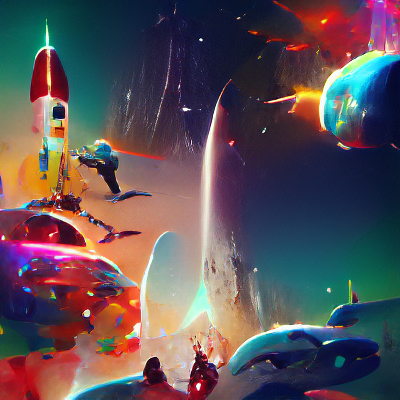

Current frame: 5/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.5 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 6/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.6000000000000001 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 7/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.7000000000000001 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 8/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.8 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 9/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 0.9 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

i: 10, loss: 0.700622, losses: 0.700622


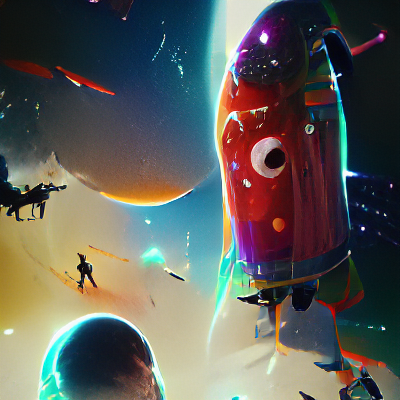

Current frame: 10/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 11/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.1 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 12/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.2000000000000002 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 13/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.3 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 14/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.4000000000000001 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

i: 15, loss: 0.706244, losses: 0.706244


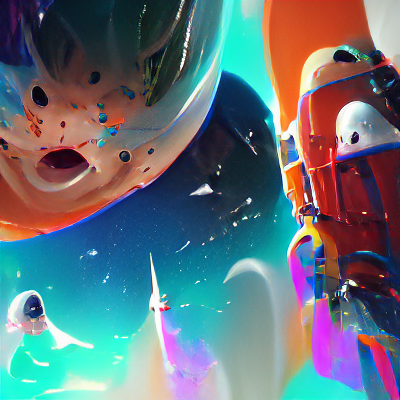

Current frame: 15/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.5 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 16/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.6 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 17/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.7000000000000002 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 18/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.8 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 19/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 1.9000000000000001 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

i: 20, loss: 0.712787, losses: 0.712787


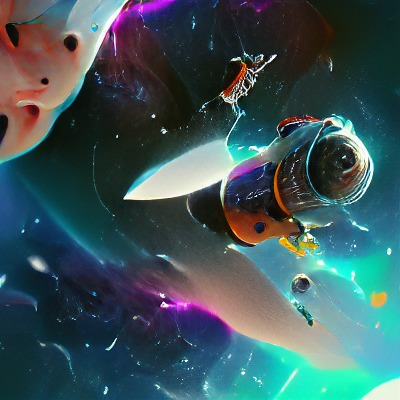

Current frame: 20/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 2.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 21/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 2.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 22/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 2.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 23/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 2.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

Current frame: 24/25
text_prompts: ['outer space adventure trending on artstation: 1.0']angle: 2.0 zoom: 1.3 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 20


0it [00:00, ?it/s]

i: 25, loss: 0.715352, losses: 0.715352


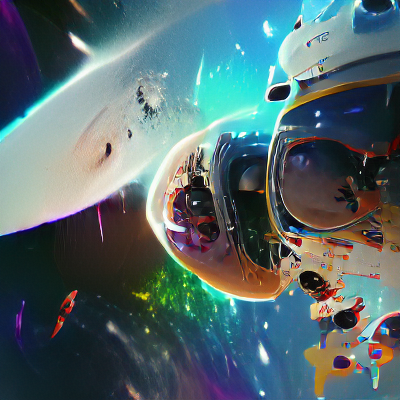

Cloning into 'arXiv2020-RIFE'...
remote: Enumerating objects: 1725, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 1725 (delta 11), reused 6 (delta 2), pack-reused 1698
Receiving objects: 100% (1725/1725), 4.04 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (1084/1084), done.
Downloading...
From: https://drive.google.com/uc?id=1wsQIhHZ3Eg4_AfCXItFKqqyDMB4NS0Yd
To: /content/arXiv2020-RIFE/RIFE_trained_model_HDv2.zip
100% 105M/105M [00:00<00:00, 186MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 105060520 bytes (101 MiB)

Extracting archive: RIFE_trained_model_HDv2.zip
--
Path = RIFE_trained_model_HDv2.zip
Type = zip
Physical Size = 105060520

  0%     15% 1 - train_log/flownet.pkl

Loaded v2.x HD model.
 96% 24/25 [00:01<00:00, 12.03it/s]
The video is ready


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title #**Generate**
#@markdown ---
#@markdown ##Interpolate results after generation
auto_interpolate = True #@param {type:"boolean"}
smoothing_exponent =  3#@param {type:"integer"}
scale =  1#@param

scale = float(scale)

#@markdown ---
#@markdown ##Convert to video

generate_video = True #@param {type:"boolean"}
fps = 30#@param {type:"number"}
auto_download_video = True #@param {type:"boolean"}

#@markdown ---
#@markdown *Interpolation, video generation, and downloading is not stable when using Drive as working directory. When using Drive, zipping and downloading the individual frames is recommended.*
#@markdown *You can zip and download frames in the next cell after generation is complete.*

# Delete memory from previous runs
!nvidia-smi -caa
for var in ['device', 'model', 'perceptor', 'z']:
  try:
      del globals()[var]
  except:
      pass

try:
    import gc
    gc.collect()
except:
    pass

try:
    torch.cuda.empty_cache()
except:
    pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if not key_frames:
    if text_prompts:
        print('Using text prompts:', text_prompts)
    if target_images:
        print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)
 
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
 
cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

for i in range(max_frames):
    print(f'Current frame: {i}/{max_frames}')
    if stop_on_next_loop:
      break
    if key_frames:
        text_prompts = text_prompts_series[i]
        text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
        if text_prompts == ['']:
            text_prompts = []
        args.prompts = text_prompts

        target_images = target_images_series[i]

        if target_images == "None" or not target_images:
            target_images = []
        else:
            target_images = target_images.split("|")
            target_images = [image.strip() for image in target_images]
        args.image_prompts = target_images

        angle = angle_series[i]
        zoom = zoom_series[i]
        translation_x = translation_x_series[i]
        translation_y = translation_y_series[i]
        iterations_per_frame = iterations_per_frame_series[i]
        print(
            f'text_prompts: {text_prompts}'
            f'angle: {angle}',
            f'zoom: {zoom}',
            f'translation_x: {translation_x}',
            f'translation_y: {translation_y}',
            f'iterations_per_frame: {iterations_per_frame}'
        )
    try:
        if i == 0 and initial_image != "":
            img_0 = read_image_workaround(initial_image)
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        elif i == 0 and not os.path.isfile(f'{working_dir}/steps/{i:04d}.png'):
            one_hot = F.one_hot(
                torch.randint(n_toks, [toksY * toksX], device=device), n_toks
            ).float()
            z = one_hot @ model.quantize.embedding.weight
            z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
        else:
            if save_all_iterations:
                img_0 = read_image_workaround(
                    f'{working_dir}/steps/{i:04d}_{iterations_per_frame}.png')
            else:
                img_0 = read_image_workaround(f'{working_dir}/steps/{i:04d}.png')

            center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
            trans_mat = np.float32(
                [[1, 0, translation_x],
                [0, 1, translation_y]]
            )
            rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

            trans_mat = np.vstack([trans_mat, [0,0,1]])
            rot_mat = np.vstack([rot_mat, [0,0,1]])
            transformation_matrix = np.matmul(rot_mat, trans_mat)

            img_0 = cv2.warpPerspective(
                img_0,
                transformation_matrix,
                (img_0.shape[1], img_0.shape[0]),
                borderMode=cv2.BORDER_WRAP
            )
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        i += 1

        z_orig = z.clone()
        z.requires_grad_(True)
        opt = optim.Adam([z], lr=args.step_size)

        normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                        std=[0.26862954, 0.26130258, 0.27577711])

        pMs = []

        for prompt in args.prompts:
            txt, weight, stop = parse_prompt(prompt)
            embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for prompt in args.image_prompts:
            path, weight, stop = parse_prompt(prompt)
            img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
            batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
            embed = perceptor.encode_image(normalize(batch)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
            gen = torch.Generator().manual_seed(seed)
            embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
            pMs.append(Prompt(embed, weight).to(device))

        def synth(z):
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
            return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

        def add_xmp_data(filename):
            imagen = ImgTag(filename=filename)
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            if args.prompts:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            else:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', model_name, {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.close()

        def add_stegano_data(filename):
            data = {
                "title": " | ".join(args.prompts) if args.prompts else None,
                "notebook": "VQGAN+CLIP",
                "i": i,
                "model": model_name,
                "seed": str(seed),
            }
            lsb.hide(filename, json.dumps(data)).save(filename)

        @torch.no_grad()
        def checkin(i, losses):
            losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
            tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
            out = synth(z)
            TF.to_pil_image(out[0].cpu()).save('progress.png')
            add_stegano_data('progress.png')
            add_xmp_data('progress.png')
            display.display(display.Image('progress.png'))

        def save_output(i, img, suffix=None):
            filename = \
                f"{working_dir}/steps/{i:04}{'_' + suffix if suffix else ''}.png"
            imageio.imwrite(filename, np.array(img))
            add_stegano_data(filename)
            add_xmp_data(filename)

        def ascend_txt(i, save=True, suffix=None):
            out = synth(z)
            iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

            result = []

            if args.init_weight:
                result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

            for prompt in pMs:
                result.append(prompt(iii))
            img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
            img = np.transpose(img, (1, 2, 0))
            if save:
                save_output(i, img, suffix=suffix)
            return result

        def train(i, save=True, suffix=None):
            opt.zero_grad()
            lossAll = ascend_txt(i, save=save, suffix=suffix)
            if i % args.display_freq == 0 and save:
                checkin(i, lossAll)
            loss = sum(lossAll)
            loss.backward()
            opt.step()
            with torch.no_grad():
                z.copy_(z.maximum(z_min).minimum(z_max))

        with tqdm() as pbar:
            if iterations_per_frame == 0:
                save_output(i, img_0)
            j = 1
            while True:
                suffix = (str(j) if save_all_iterations else None)
                if j >= iterations_per_frame:
                    train(i, save=True, suffix=suffix)
                    break
                if save_all_iterations:
                    train(i, save=True, suffix=suffix)
                else:
                    train(i, save=False, suffix=suffix)
                j += 1
                pbar.update()
    except KeyboardInterrupt:
      stop_on_next_loop = True
      pass

#####

if auto_interpolate:
  smoothing_exponent = 2
  scale =  1

  scale = float(scale)

  !git clone https://github.com/hzwer/arXiv2020-RIFE
  !gdown --id 1wsQIhHZ3Eg4_AfCXItFKqqyDMB4NS0Yd
  !7z e RIFE_trained_model_HDv2.zip

  !mkdir /content/arXiv2020-RIFE/train_log
  !mv *.pkl /content/arXiv2020-RIFE/train_log/
  %cd /content/arXiv2020-RIFE/

  !gdown --id 1i3xlKb7ax7Y70khcTcuePi6E7crO_dFc
  !pip3 install -r requirements.txt

  !python3 inference_video.py --exp={smoothing_exponent} --img=../steps/ --scale={scale}

####

if generate_video:
  # import subprocess in case this cell is run without the above cells
  import subprocess

  init_frame = 1
  try:
    smoothing_exponent
    last_frame = max_frames * ( 2 ** smoothing_exponent) - 4
  except:
    last_frame = max_frames

  frames = []
  # tqdm.write('Generating video...')
  try:
    smoothing_exponent
  except NameError:
      image_path = f'{working_dir}/steps/%04d.png'
  else:
      image_path = f'{working_dir}/arXiv2020-RIFE/vid_out/%07d.png'

  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-c:v',
      'libx264',
      '-frames:v',
      str(last_frame-init_frame),
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      f'{working_dir}/out.mp4'
  ]

  process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      print(
          "You may be able to avoid this error by backing up the frames,"
          "restarting the notebook, and running only the video synthesis cells,"
          "or by decreasing the resolution of the image generation steps. "
          "If you restart the notebook, you will have to define the `filepath` manually"
          "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
          "If these steps do not work, please post the traceback in the github."
      )
      raise RuntimeError(stderr)
  else:
      print("The video is ready")
  
  if auto_download_video:
    from google.colab import files
    files.download(f'{working_dir}/out.mp4')

In [ ]:
#@title Download images

download_images = False #@param {type:"boolean"}


if download_images:
  # For now, just download the images and process manually on local computer
  from google.colab import files

  path = f'{working_dir}/steps.zip'
  #!rm {path}

  !zip -r {working_dir}/steps.zip {working_dir}/steps/

  #files.download(path)